<a href="https://colab.research.google.com/github/solobala/FEML23/blob/master/FEML23_DZ2_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Домашнее задание к занятию Функции потерь и оптимизация
===========

## 1. Загрузите данные. Используйте датасет с ирисами. Его можно загрузить непосредственно из библиотеки Sklearn. В данных оставьте только 2 класса: Iris Versicolor, Iris Virginica.

### Импорт необходимых библиотек

In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as sts
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn import datasets

# from tensorflow import keras
# from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns


### Загрузка датасета

In [ ]:
iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns=iris.feature_names)
data_class = iris.target
data['target']=data_class
data = data[data['target']!=0]
data.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
50,7.0,3.2,4.7,1.4,1
51,6.4,3.2,4.5,1.5,1
52,6.9,3.1,4.9,1.5,1
53,5.5,2.3,4.0,1.3,1
54,6.5,2.8,4.6,1.5,1


### Проверка нормальности распределения признаков

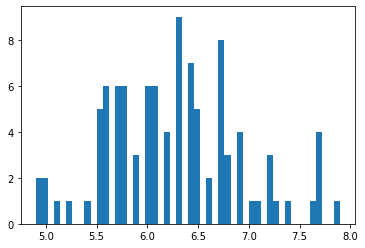

In [ ]:
plt.hist(data["sepal length (cm)"], bins=50);

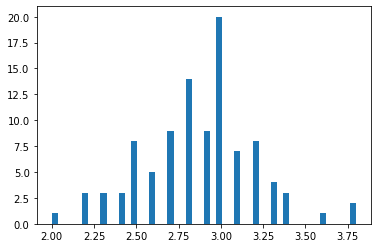

In [ ]:
plt.hist(data["sepal width (cm)"], bins=50);

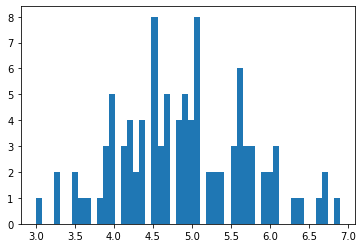

In [ ]:
plt.hist(data["petal length (cm)"], bins=50);

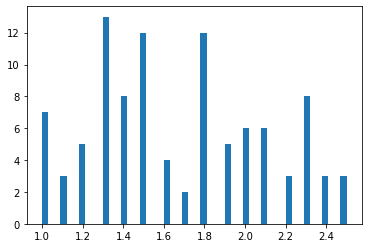

In [ ]:
plt.hist(data["petal width (cm)"], bins=50);

In [ ]:
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

from numpy.random import seed

In [ ]:
def shapiro_test(df,names):
    """
    Служебная функция для вывода информации по тесту Шапиро-Уилкса
    """
    seed(1)
    for name in names:
        stat, p = shapiro(df[name])
        print(name)
        print('Statistics=%.3f, p=%.3f' % (stat, p))
        alpha = 0.05
        if p > alpha:
            print('Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)')
        else:
            print('Отвергаем H0 о нормальности распределения')
        print()

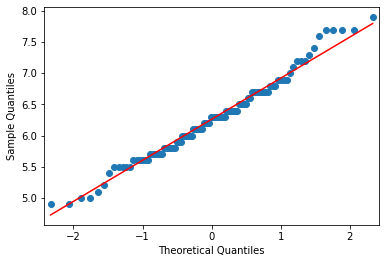

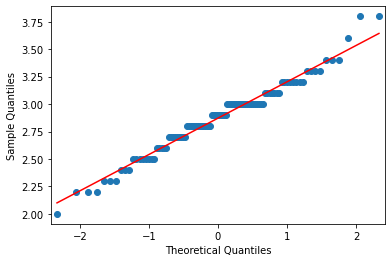

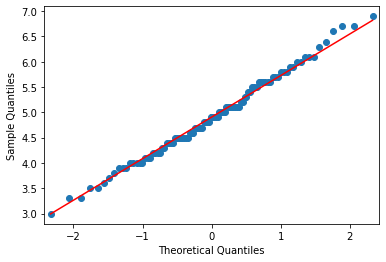

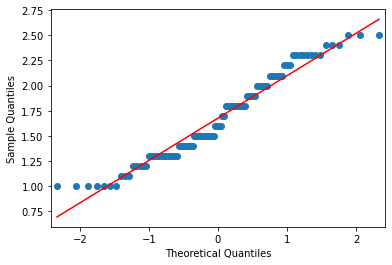

In [ ]:
seed(1)
qqplot(data["sepal length (cm)"], line='s')
qqplot(data["sepal width (cm)"], line='s')
qqplot(data["petal length (cm)"], line='s')
qqplot(data["petal width (cm)"], line='s')
plt.show()

In [ ]:
shapiro_test(data,["sepal length (cm)", "sepal width (cm)", "petal length (cm)","petal width (cm)"])

sepal length (cm)
Statistics=0.981, p=0.146
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)

sepal width (cm)
Statistics=0.980, p=0.126
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)

petal length (cm)
Statistics=0.991, p=0.745
Предположительно нормальное распределение (Недостаточно данных, чтобы отвергнуть H0)

petal width (cm)
Statistics=0.952, p=0.001
Отвергаем H0 о нормальности распределения



### Проверка сбалансированности классов

In [ ]:
data['target'].value_counts() 

1    50
2    50
Name: target, dtype: int64

Классы сбалансированы, для оценки качества работы модели можно будет использовать accuracy

### Подготовка векторов признаков и целевой переменной для последующего моделирования

In [ ]:
y = data['target'].to_numpy()
X = data.iloc[:, 0:4]

In [ ]:
# Перекодируем target, т.к для бинарной классификации нужны метки классов 1 и 0, а в датасете 1 и 2
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

### Разбивка датасета на обучающее и тестовое подмножества

In [ ]:
"""
Чтобы получить воспроизводимые (т. е. постоянные) результаты при выполнении 
нескольких программ , нам нужно удалить все варианты использования 
random_state=None, что является значением по умолчанию. Рекомендуемый способ — 
объявить rng переменную в верхней части программы и передать ее любому объекту, 
принимающему random_state параметр.
Мы не рекомендуем устанавливать глобальное numpyначальное число путем вызова 
np.random.seed(0). Смотрите здесь для обсуждения. Цитата из документации 
scikit-learn https://scikit-learn.ru/10-3-controlling-randomness/
"""
rng = np.random.RandomState(0)


In [ ]:
# 80%/20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = rng)

In [ ]:
def init_weights(X, rng):
  # Зададим начальные веса для всех алгоритмов  и 1 - для фиктивного признака
  random_state = rng
  one = np.array([[1.]])
  W0 = np.random.normal(size=X.shape[1],) 
  W0 = np.expand_dims(W0, axis=-1) 
  W = np.concatenate((one, W0), axis=0)
  return W

In [ ]:
W = init_weights(X, rng)
print(W)

[[ 1.        ]
 [ 1.62434536]
 [-0.61175641]
 [-0.52817175]
 [-1.07296862]]


## 2. Самостоятельно реализуйте логистическую регрессию, без использования метода LogisticRegression из библиотеки. Можете использовать библиотеки pandas, numpy, math для реализации. Оформите в виде функции. *Оформите в виде класса с методами.

In [ ]:
class MyClassificator:

  def __init__(self, epoch=100, learning_rate=0.01, learn_method='gd', stop_rate=0.0001, random_state=42,weights=[[0.],[0.],[0.],[0.],[0.]]): 
    self.epoch = epoch 
    self.learn_method = learn_method 
    self.learning_rate = learning_rate 
    self.stop_rate = stop_rate 
    self.learn_func = None 
    self.cost_func = None 
    # self.weights = None
    self.weights = weights
    self.epoch_passed = 0
    self.learn_time = 0
    self.random_state = random_state

    if(self.learn_method == 'gd'):
      self.learn_func = self.gd
    elif(self.learn_method == 'rmsprop'):
      self.learn_func = self.rmsprop
    elif(self.learn_method == 'nadam'):
      self.learn_func = self.nadam
    else:
      raise Exception('Unknown learining method: {}'.format(self.learn_method))


  def init_weights(self,X):
    """
    Ф-я должна задавать начальные веса. Но если она их будет выбирать случайным образом,
    мы не сможем сопоставить результаты работы разных алгоритмов.
    Можно бы задать все 0 кроме 1 признака =1, но это неинтересн0, т.к не сможем 
    проверить быстроту сходимости алгоритмов  взависимости от выбора начальной точки
    Поэтому начальные веса задаем случайным образом во внешней программе,
    и значения передаем в класс
    """
  
    # Будем использовать состояние генератора, сгенерированное в основной программе,
    # чтобы обеспечить равные начальные условия для всех алгоритмов

    # random_state = self.random_state
    # W = np.random.normal(size=X.shape[1],) 
    # W = np.expand_dims(W, axis=-1) 
    #return np.random.randn(X.shape[1], 1);
    # return np.zeros((X.shape[1], 1))
    W = self.weights
    return W


  def fit(self,X,Y):
    """
    Ф-я выполняет обучение модели
    """
    X = self.add_ones(X) # добавляем фиктивный признак
    Y = np.reshape(Y, (len(Y), 1)) # преобразуем в вектор
    W = self.init_weights(X) # выбираем начальные значения весов

    self.epoch_passed = 0
    self.learn_time = 0

    start = time.perf_counter()
    self.learn_func(X,Y,W) # начинаем обучение
    self.learn_time = time.perf_counter() - start


  def score(self,X,Y):
    """
    Ф-я возвращает accuracy - долю количества правильных ответов от общего
    кол-ва ответов обученной модели
 
    """
    predictions = self.predict(X)
    scores = []

    for idx, y_pred in enumerate(predictions):
      scores.append(True if y_pred == Y[idx] else False)
      accuracy = scores.count(True)/len(scores)

    return accuracy


  def n_iter(self):
    """
    Ф-я возвращает к-во итераций обучения
    """
    return self.epoch_passed


  def time(self):
    """
     Ф-я  возвращает время обучения
    """
    return self.learn_time    


  def predict_proba(self,X):
    """
    Ф-я возвращает вероятности принадлежности к целевому классу
    для каждой из точек датасета
    """
    X = self.add_ones(X)
    return self.sigmoid_linear_regression(X,self.weights)

 
  def predict(self,X):
    """
    Ф-я переводит плученную вероятность принадлежности к целевому классу
    в метку класса и таким образом предсказывает ответ обученной модели 
    на основании значений признаков
    """
    probas = self.predict_proba(X)
    for idx, y in enumerate(probas):
      probas[idx] = 1 if y > 0.5 else 0

    return probas

 
  def add_ones(self,X):
    """
    Ф-я добавляет фикитвный единичный признак в начало вектора признаков
    """
    return np.hstack((np.ones((X.shape[0],1)),X)) # С помощью функции hstack() можно присоединять данные по горизонтальной оси к вектору
    # return x.insert(0,'x0', np.ones(x.shape[0])) # можно и так


  def gd(self,X,Y,W):
    """
    метод, реализующий  градиентный спуск (GD)
    """
    prev = self.cost_binary_cross_entropy(X,Y,W) # Кросс-энтропия во всех точках датасета на текущем шаге

    for i in range(self.epoch):
      self.epoch_passed = i + 1
      gradients = self.gradient(X,Y,W) # считаем градиент
     
      W = W - self.learning_rate * gradients # меняем веса (к-ты линейной регрессии)
      actual = self.cost_binary_cross_entropy(X,Y,W) # кросс-энтропия на след. шаге
      diff = abs(prev - actual)

      if(diff <= self.stop_rate):
        break
      prev = actual #след. шаг становится текущим
      
    self.weights = W # Обновляем веса
   
    return W   

 
  def rmsprop(self,X,Y,W):
    """
    метод, реализующий улучшенный градиентный спуск
    на основе скользящего среднего (Root Mean Square Propagation, RMSProp)
    """
    prev = self.cost_binary_cross_entropy(X,Y,W) # значение ф-ии потерь на старте
    lr = self.learning_rate
    s = [0] * len(W) # начальные значения
    rho = 0.9 # гиперпараметр rho

    for i in range(self.epoch):
      self.epoch_passed = i + 1
      gradients = self.gradient(X, Y, W)
      NEW_W = []
   
      for j, (w, grad) in enumerate(zip(W, gradients)):

        # s[j-1]  затухающая скользящая средняя квадрата частной производной для предыдущей итерации
        # s[j] затухающая скользящая средняя квадрата частной производной для текущей итерации
        s[j] = rho * s[j] + (1 - rho) * grad **2
        
        #пользовательский размер шага для вектора признаков
        cust_step_size = lr/(1e-8 + np.sqrt(s[j]))
        # новое значение вектора весов для данной точки
        new_w = w - cust_step_size * grad
    
        NEW_W.append(new_w) # собираем новые вектора весов для всех точек
  
      W = np.array(NEW_W)
      actual = self.cost_binary_cross_entropy(X, Y, W) # значение ф-ии потерь на текущем шаге
      diff = abs(prev - actual)
      if(diff <= self.stop_rate):
        break
      prev = actual
      
    self.weights = W
    return W

  
 
  def nadam(self,X,Y,W):
    """
    метод, реализующий улучшенный градиентный спуск
    на основе ускоренного по Нестерову метода адаптивной оценки моментов NADAM -
    Nesterov-accelerated Adaptive Moment Estimation.
    NADAM является расширением ADAM, в котором вместо классического импульса 
    используется импульс NAG.
    NADAM использует затухающий размер шага ( lr ) и гиперпараметры 
    первого момента ( mu, nu ), которые могут повысить производительность
    
    """
    prev = self.cost_binary_cross_entropy(X,Y,W)
    lr = self.learning_rate

    # m,n - первый и второй моменты градиента
 
    m = np.array([0.] * len(W))
    n = np.array([0.] * len(W))

    # Гиперпараметры
    mu = 0.9
    nu = 0.999

    for t in range(self.epoch):
      self.epoch_passed +=1
      gradients = self.gradient(X,Y,W)

      for i in range(len(W)):
        m[i] = mu * m[i] + (1.0 - mu) * gradients[i]
        n[i] = nu * n[i] + (1.0 - nu) * gradients[i]**2

        # корректировка 1 и 2 моментов
        mhat = (mu * m[i] / (1.0 - mu)) + ((1 - mu) *gradients [i] / (1.0 - mu))
        nhat = nu * n[i] / (1.0 - nu)

        # пересчет весов
        W[i] = W[i] - lr / (np.sqrt(nhat) + 1e-9) * mhat

      
      actual = self.cost_binary_cross_entropy(X, Y, W)
      diff = abs(prev - actual)
      if(diff <= self.stop_rate):
        break
      prev = actual
      
    self.weights = W
    return W


  def cost_binary_cross_entropy(self, X, Y, W):
    """
    функция бинарной кросс-энтропии, или
    функция логистической ошибки, 
    или log loss
    или функция потерь для логистической регрессии
    """
    m = X.shape[0]

    total_cost = -(1 / m) * np.sum(Y * np.log(self.sigmoid_linear_regression(X, W) + 1e-9) + 
        (1 - Y) * np.log(1 - self.sigmoid_linear_regression(X, W) + 1e-9))
    
    return total_cost    

  
  def gradient(self, X, Y, W):
    """
    производная от функции бинарной кросс-энтропии
    Производная  бинарной кросс-энтропии для классов 1 и 0 вывод см.
    https://www.dmitrymakarov.ru/opt/logistic-regression-05/
    
    """
    m = X.shape[0]
    return (1 / m) * np.dot(X.T, self.sigmoid_linear_regression(X, W) - Y)    

  
  def sigmoid_linear_regression(self, X, W):
    """
    главная функция логистической регрессии
    аргумент у сигмоиды - ф-я линейной регрессии
    на выходе - вероятность принадлежности целевому классу
    """
    return self.sigmoid(self.linear_regression(X, W))
   

  
  def linear_regression(self, X, W):
    """
    функция линейной регрессии
    X - вектор признаков, включая фиктивный,который добавлен с помощью ф-ии add_ones
    """
    
    return np.dot(X,W)

 
  def sigmoid(self, H):
    """
    функция сигмоиды (логистическая функция) или
    функция логистического отклика или 
    функция обратного логит-преобразования.
    При очень больших отрицательных или положительных значениях H может 
    возникнуть переполнение памяти (overflow)
    Ф-я позволяет преодолеть это ограничение и добиться вычислительной 
    устойчивости (numerical stability)
    """
    
    if H.all() >= 0:
      return 1 / (1 + np.exp(-H))
    else:
      return np.exp(H) / (np.exp(H) + 1) 
    # return 1/(1 + np.exp(-H))




### 3. Реализуйте метод градиентного спуска. Обучите логистическую регрессию этим методом. Выберете и посчитайте метрику качества. Метрика должна быть одинакова для всех пунктов домашнего задания. Для упрощения сравнения выберете только одну метрику.

В качестве метрики качества для разных алгоритмов градиентного спуска была выбрана средняя accuracy (score) - доля правильных ответов. 
Для сравнения также использовались:
- количество эпох для обучения (к-во итераций для "схождения" функции потерь)
- время обучения
- скорость обучения

In [ ]:
full_results = pd.DataFrame(columns=['Method','Score','Iterations','Learning_Rate','Time','start_weights', 'model.coef_', 'model.intercept_']) # Здесь будут хранится лучшие для каждого метода результаты сравнительного анализа

In [ ]:
iters = [1000] # максимальное к=во итераций
rates = [0.01] # сКорость обучения. Первоначально тестировался список 0.01, 0.001, 0.0001, наиболее целесообразно на данном датасете для всех трех методов по достигнутям accuracy, iterations, time оказалось использовать 0.01
tries = 1000 # кол-во вариантов различных начальных точек

Сначала проверим, какой результат дает реализация на базе SKLEARN

In [ ]:
# SKLEARN с установками по-умолчанию и фиксацией  random_state
import time
results = pd.DataFrame(columns=['Method','Score','Iterations','Learning_Rate','Time','start_weights', 'model.coef_', 'model.intercept_'])
for max_iter in iters:
  start = time.perf_counter() #возвращает значение в долях секунды счетчика производительности
  model = LogisticRegression(random_state=rng, max_iter=max_iter)
  model.fit(X_train,y_train)
  accuracy = model.score(X_test, y_test)
  iter = model.n_iter_[0]
  full_time = time.perf_counter() - start
  results.loc[len(results)] = ['SKLEARN DEFAULT',accuracy,iter,'',full_time,'',model.coef_, model.intercept_]


In [ ]:
#Сохраним один самый лучший результат
r2 = results.sort_values(by=['Score','Time','Iterations']).loc[[0]]
full_results = pd.concat([full_results, r2], ignore_index= True) 
full_results.head() 

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
0,SKLEARN DEFAULT,0.9,26,,0.016954,,"[[-0.2737773304736526, -0.5778984375380704, 2....",[-13.964164303114424]


В стандартной реализации сходимость достигается за 26 итераций. На скорость обучения и выбор начальной точки мы здесь повлиять не можем, таким образом, задаваемое максимальное число итераций ни на что не влияет. однако в процессе запусков выяснилось, что время обучения модели все-таки меняется. Почему так происходит?

## 4. Повторите п. 3 для метода скользящего среднего (Root Mean Square Propagation, RMSProp).


https://machinelearningmastery.com/gradient-descent-with-rmsprop-from-scratch/

## 5. Повторите п. 3 для ускоренного по Нестерову метода адаптивной оценки моментов (Nesterov–accelerated Adaptive Moment Estimation, Nadam).

https://machinelearningmastery.com/gradient-descent-optimization-with-nadam-from-scratch/

Для всех 3 методов написан общий класс. Поэтому пп.3,4,5 реализованы в коде ниже.

Проведена серия оценочных вычислений с переменными скоростью обучения и максимальным числом итераций. Наилучшие результаты ( по accuracy, Time, Iteration) были получены для learning_rate = 0.01  и максимального числа итераций 1000, поэтому указанные значения были выбраны в качестве базовых в дальнейших исследованиях.

Кроме того, в предварительных исследованиях была выявлена сильная зависимость значений accuracy, к-ва итераций и времени обучения от выбора начальных значений весов. Поэтому было зафиксировано random_state, и для данного состояния последовательно генерировались начальные значения весов, которые подавались на вход во все три алгоритма. 

Для оценки работы реализаций алгоритмов была выполнена серия вычислений по 1000 попыток для каждого алгоритма. 


In [ ]:
results = pd.DataFrame(columns=['Method','Score','Iterations','Learning_Rate','Time','start_weights',  'model.coef_', 'model.intercept_'])
for i in range(tries):
  # Задаема начальные веса, тут без разницы, X, X_train Или X_test - здесь важно к-во признаков с учетом фиктивного
  W_start = init_weights(X, rng) 

  for method in ['gd', 'rmsprop', 'nadam']:
    
    for lr in rates:  # может быть задано несколько значений lr

      for max_iter in iters:  # может быть задано несколько значений max_iter

        model = MyClassificator(learn_method=method, learning_rate=lr, epoch=max_iter, random_state=rng, weights=W_start)
        model.fit(X_train,y_train)
        accuracy = model.score(X_test, y_test)
        iter = model.n_iter()
        full_time = model.time()
        # Сохраняем результаты попыток  в датафрейм
        results.loc[len(results)] = [method, accuracy, iter,lr, full_time, W_start, model.weights[1::], model.weights[0]]

# Добавляем его в общий датафрейм с результатами SKLEARN DEFAULT ( таким образом, для каждого метода здесь будет tries записей) 
full_results = pd.concat([full_results, results], ignore_index= True) 


In [ ]:
full_results.shape

(3001, 8)

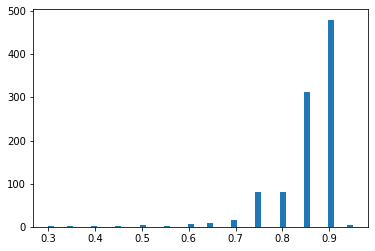

In [ ]:
plt.hist(full_results[full_results['Method']=='gd']['Score'], bins=50)
plt.show()

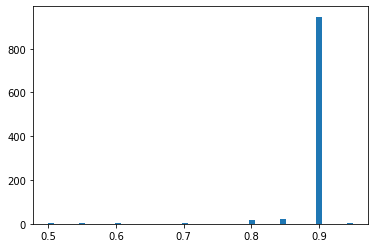

In [ ]:
plt.hist(full_results[full_results['Method']=='rmsprop']['Score'], bins=50)
plt.show()

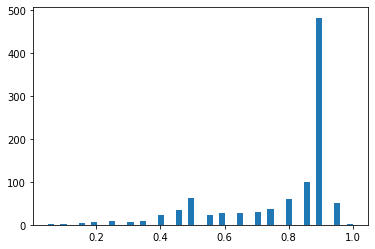

In [ ]:
plt.hist(full_results[full_results['Method']=='nadam']['Score'], bins=50)
plt.show()

По гистограммам видно, что распределение у accuracy - не нормальное, напоминает экспоненциальное. Сравнение работы алгоритмов будем производить не по среднему значению, а по моде

## 6. Сравните значение метрик для реализованных методов оптимизации. Можно оформить в виде таблицы вида |метод|метрика|время работы| (время работы опционально). Напишите вывод.


Результаты работы алгоритмов собирались в латафрейм full_results.

Сравнение происходило по следующим позициям:
- доля правильных ответов (accuracy/score)
- количество итераций для обучения (iterations)
- время обучения (time)




In [ ]:
print('accuracy : learning_rate = 0.01, макс. к-во итераций 1000')
print(f"SKLEARN DEFAULT: mode = {full_results[full_results['Method']=='SKLEARN DEFAULT']['Score'].mode()[0]}")
print(f"gd: mode = {full_results[full_results['Method']=='gd']['Score'].mode()[0]}")
print(f"rmsprop: mode = {full_results[full_results['Method']=='rmsprop']['Score'].mode()[0]}")
print(f"nadam: mode = {full_results[full_results['Method']=='nadam']['Score'].mode()[0]}")

accuracy : learning_rate = 0.01, макс. к-во итераций 1000
SKLEARN DEFAULT: mode = 0.9
gd: mode = 0.9
rmsprop: mode = 0.9
nadam: mode = 0.9


In [ ]:
print('learning time : learning_rate = 0.01, макс. к-во итераций 1000')
print(f"SKLEARN DEFAULT: mode = {full_results[full_results['Method']=='SKLEARN DEFAULT']['Time'].mode()[0]}")
print(f"gd: mode = {full_results[full_results['Method']=='gd']['Time'].mode()[0]}")
print(f"rmsprop: mode = {full_results[full_results['Method']=='rmsprop']['Time'].mode()[0]}")
print(f"nadam: mode = {full_results[full_results['Method']=='nadam']['Time'].mode()[0]}")



learning time : learning_rate = 0.01, макс. к-во итераций 1000
SKLEARN DEFAULT: mode = 0.016954263000116043
gd: mode = 0.0015853009999773349
rmsprop: mode = 0.0098517209999045
nadam: mode = 0.0005623520000881399


In [ ]:
print('Iteraions : learning_rate = 0.01, макс. к-во итераций 1000')
print(f"SKLEARN DEFAULT: mode = {full_results[full_results['Method']=='SKLEARN DEFAULT']['Iterations'].mode()[0]}")
print(f"gd: mode = {full_results[full_results['Method']=='gd']['Iterations'].mode()[0]}")
print(f"rmsprop: mode = {full_results[full_results['Method']=='rmsprop']['Iterations'].mode()[0]}")
print(f"nadam: mode = {full_results[full_results['Method']=='nadam']['Iterations'].mode()[0]}")

Iteraions : learning_rate = 0.01, макс. к-во итераций 1000
SKLEARN DEFAULT: mode = 26
gd: mode = 1000
rmsprop: mode = 779
nadam: mode = 1000


Таким образом, при равной accuracy наименьшая мода времени обучения у nadam, затeм у gd, rmsprop, худший результат - у SKLEARN DEFAULT. Наименьшая мода числа итераций наоборот, у SKLEARN DEFAULT, у реализаций алгоритмов мода значительно больше.Получается, что в большинстве случаев для достижения сходимости алгоритмам gd и nadam потребовалось максимально возможное кол-во итераций

В то же время, топовые результаты по accuracy по всем 3 алгоритмам  превосходят результаты SKLEARN DEFAULT

In [ ]:
full_results[(full_results['Score'] >= 0.95) & (full_results['Method'] == 'gd')].sort_values(by=['Method','Score','Time','Iterations'], ascending=[True, False, True, True]).head(1)

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
2323,gd,0.95,39,0.01,0.002961,"[[1.161041439882987], [-1.154819017316854], [-...","[[-1.057481357316182], [-0.8525477764839625], ...",[1.0405797887854265]


In [ ]:
full_results[(full_results['Score'] >= 0.95) & (full_results['Method'] == 'rmsprop')].sort_values(by=['Method','Score','Time','Iterations'], ascending=[True, False, True, True]).head(1)

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
2201,rmsprop,0.95,123,0.01,0.016777,"[[0.6883989915765354], [-0.6832416934489502], ...","[[-1.0588355171852633], [-0.4772905371062189],...",[0.032658327406904775]


In [ ]:
full_results[(full_results['Score'] >= 0.95) & (full_results['Method'] == 'nadam')].sort_values(by=['Method','Score','Time','Iterations'], ascending=[True, False, True, True]).head(1)

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
1452,nadam,1.0,1000,0.01,0.192402,"[[-1.4841636121793742], [0.16793948273625664],...","[[0.16793948273625664], [-0.31424148649251515]...",[-1.4841636121793742]


Если же сравнивать, зафиксировав accuracy на уровне 0.9, то и здесь реализации демонстрируют превосходство во времени обучения и к-ве итераций

In [ ]:
full_results[(full_results['Score'] == 0.9) & (full_results['Method'] == 'gd')].sort_values(by=['Method','Score','Time','Iterations'], ascending=[True, False, True, True]).head(1)

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
997,gd,0.9,11,0.01,0.001585,"[[-1.9525373896196274], [-2.3735385820398855],...","[[-0.7105511623371771], [-1.7159401730125035],...",[0.9967998900863646]


In [ ]:
full_results[(full_results['Score'] == 0.9) & (full_results['Method'] == 'rmsprop')].sort_values(by=['Method','Score','Time','Iterations'], ascending=[True, False, True, True]).head(1)

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
1277,rmsprop,0.9,82,0.01,0.012338,"[[-1.8046066402011298], [-1.1780926649548393],...","[[-0.37764485634741884], [-2.241834804735076],...",[0.4302890172529284]


In [ ]:
full_results[(full_results['Score'] == 0.9) & (full_results['Method'] == 'nadam')].sort_values(by=['Method','Score','Time','Iterations'], ascending=[True, False, True, True]).head(1)

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_
405,nadam,0.9,2,0.01,0.000562,"[[1.0198328869925393], [-0.35859380153514114],...","[[-0.35859380153514114], [-1.7173527708367435]...",[1.0198328869925393]


В примерах выше показаны лучшие результаты, достигнутые алгоритмыми, но градиентный спуск в них происходит от разных начальных точек. Получим сравнение эффективности алгоритмов для одинаковых начальных условий. Зафиксируем, к примеру, точку 405, в которой nadam получил результат за 2 итерации

In [ ]:
a= full_results.start_weights[405]
full_results['check']=full_results.apply(lambda row:np.array_equal(row.start_weights,a), axis=1 )
full_results[full_results['check']==True].sort_values(by=['Score', 'Time', 'Iterations'])

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_,check
405,nadam,0.9,2,0.01,0.000562,"[[1.0198328869925393], [-0.35859380153514114],...","[[-0.35859380153514114], [-1.7173527708367435]...",[1.0198328869925393],True
403,gd,0.9,392,0.01,0.028483,"[[1.0198328869925393], [-0.35859380153514114],...","[[-0.55408975683319], [-1.8353023374972348], [...",[0.901825450931134],True
404,rmsprop,0.9,643,0.01,0.098294,"[[1.0198328869925393], [-0.35859380153514114],...","[[-2.336832753237653], [-3.8072072387107374], ...",[-4.02067659288946],True


При движении из данной начальной точки все 3 алгоритма показали одинаковую accuracy, но разные Time и Iterations. Лучший результат у nadam

In [ ]:
full_results.drop(['check'], axis=1,inplace=True)

Зафиксируем точку 1452, где nadam показал абсолютный рекорд = accuracy=1

In [ ]:
a= full_results.start_weights[1452]
full_results['check']=full_results.apply(lambda row:np.array_equal(row.start_weights,a), axis=1 )
full_results[full_results['check']==True].sort_values(by=['Score', 'Time', 'Iterations'])

,Method,Score,Iterations,Learning_Rate,Time,start_weights,model.coef_,model.intercept_,check
1450,gd,0.85,1000,0.01,0.135685,"[[-1.4841636121793742], [0.16793948273625664],...","[[-0.42357112441911116], [0.2333941528264516],...",[0.32865626407378473],True
1451,rmsprop,0.90,928,0.01,0.155901,"[[-1.4841636121793742], [0.16793948273625664],...","[[-1.9463928658793785], [-3.3748935565500235],...",[-6.180986281048437],True
1452,nadam,1.00,1000,0.01,0.192402,"[[-1.4841636121793742], [0.16793948273625664],...","[[0.16793948273625664], [-0.31424148649251515]...",[-1.4841636121793742],True


в этом случае алгоритмы показали не только разные время обучения и к-во итераций, но и разную accuracy

Предлагается следующая методика определения победителя. Берем для рассмотрения весь датасет full_results. Для каждой начальной точки ищется алгоритм с максимальной accuracy. Если их несколько, из них выбирается алгоритм с минимальным временем обучения. Если их опят-таки несколькоЮ выбирается алгоритм с минимальным числом итераций. Победитель шага получит 1 балл. 
Алгоритм с наибольшей суммой баллов - победитель для данного датасета и выбранных условий работы

In [ ]:
df=full_results.copy()

In [ ]:
for i in range(df.shape[0]):

  if np.isnan(df.winner[i]):

    a = df.start_weights[i]
    df['check']=df.apply(lambda row:np.array_equal(row.start_weights,a), axis=1 )
    # в B лежат номера строк с одинаковыми весами
    b = df.index[df['check']==True ].tolist ()
    candidates=df.loc[b]
    # Выберем лучший результат ( по accuracy,Time, Iterations)
    max_accuracy = max(candidates['Score'])
    #  Строки с лучшим score
    r = candidates.loc[(candidates['Score'] ==max_accuracy)]
    
    if len(r) > 1:
      min_time = min(r['Time'])
      r1 = r.loc[r['Time'] == min_time]

      if len(r1) >1:
        min_iteration = min(r1['Iterations'])
        r2 = r1.loc[r1['Iterations'] == min_iteration]
      else:
        r2 = r1
    else:
      r2 = r
    c =r2.index.to_list()
    df.loc[b,'winner']=0
    # Присуждаем очко победителю
    df.loc[c,'winner']=1

In [ ]:
result = df.groupby(by='Method').sum('winner')
result['winner']

Method
SKLEARN DEFAULT      1.0
gd                 399.0
nadam              104.0
rmsprop            497.0
Name: winner, dtype: float64

Итак, для данного датасета, зафиксированного состояния генератора случайных чисел, выбранной скорости обучения  и ограничения в виде максимального числа итераций на объеме выборки = 3000 наибольшую эффективность продемонстрировала реализация алгоритма rmsprop ( 497 баллов), второе место - у gd (399 баллов),третье - у nadam(104 балла). 
Кроме того, в ряде случаев самостоятельная реализация алгоритма благодаря возможности тонкой настройки и выбору начальных точек позволяет более эффективно решать задачу по сравнению со стандартным алгоритмом scikit-learn             

В стандартной реализации логистической регрессии accuracy составила 0.9.  В моей реализации алгоритмов gd, msprop и nadam в некоторых случаях была достигнута accuracy 0.95 и даже 1

In [ ]:
# model = keras.Sequential()
# model.add(layers.Dense(64, kernel_initializer='uniform', input_shape=(10,)))
# model.add(layers.Activation('softmax'))

# optimizer = keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,
#     weight_decay=None,
#     clipnorm=None,
#     clipvalue=None,
#     global_clipnorm=None,
#     use_ema=False,
#     ema_momentum=0.99,
#     ema_overwrite_frequency=100,
#     jit_compile=True,
#     name="RMSprop",

# )
# model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [ ]:
# from tensorflow import GradientTape

In [ ]:
# # Задаем оптимайзер
# # optimizer = keras.optimizers.Adam()

# # Движемся по датасету
# for x, y in X_train, y_train:
#     # Используем GradientTape - инструмент для автоматического дифференцирования
#     with GradientTape() as tape:
#         # Forward pass.
#         logits = model(x)

#         # Вычисляем значение ф-ии потерь на данном шаге
#         loss_value = loss_fn(y, logits)

#     # Получаем градиенты потерь относительно весов.
#     gradients = tape.gradient(loss_value, model.trainable_weights)

#     # Обновляем веса модели
#     optimizer.apply_gradients(zip(gradients, model.trainable_weights))